In [1]:
import os
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                     Dropout, BatchNormalization, 
                                     GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, InceptionV3

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# %%
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

2025-11-23 14:00:46.859663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763906447.050620      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763906447.102303      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
BASE_PATH = '/kaggle/input/object-classification'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')  # Changed to lowercase
VALID_DIR = os.path.join(BASE_PATH, 'valid')  # Changed to lowercase
TEST_DIR = os.path.join(BASE_PATH, 'test')    # Changed to lowercase

# Class names
CLASS_NAMES = ['bird', 'drone']

print(f"Base Path: {BASE_PATH}")
print(f"Train Directory: {TRAIN_DIR}")
print(f"Valid Directory: {VALID_DIR}")
print(f"Test Directory: {TEST_DIR}")


Base Path: /kaggle/input/object-classification
Train Directory: /kaggle/input/object-classification/train
Valid Directory: /kaggle/input/object-classification/valid
Test Directory: /kaggle/input/object-classification/test


In [3]:
def count_images(base_path):
    """Count images in each class for all splits"""
    data = []
    for split in ['train', 'valid', 'test']:   # <-- FIXED lowercase
        split_path = os.path.join(base_path, split)
        if os.path.exists(split_path):
            for cls in os.listdir(split_path):
                cls_path = os.path.join(split_path, cls)
                if os.path.isdir(cls_path):
                    count = len([
                        f for f in os.listdir(cls_path)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                    ])
                    data.append({
                        'Split': split.upper(),  # Better for display
                        'Class': cls,
                        'Count': count
                    })
    return pd.DataFrame(data)


BASE_PATH = "/kaggle/input/object-classification"
df_counts = count_images(BASE_PATH)

print("Dataset Distribution:")
print(df_counts.pivot(index='Class', columns='Split', values='Count'))


Dataset Distribution:
Split  TEST  TRAIN  VALID
Class                    
bird    121   1414    217
drone    94   1248    225


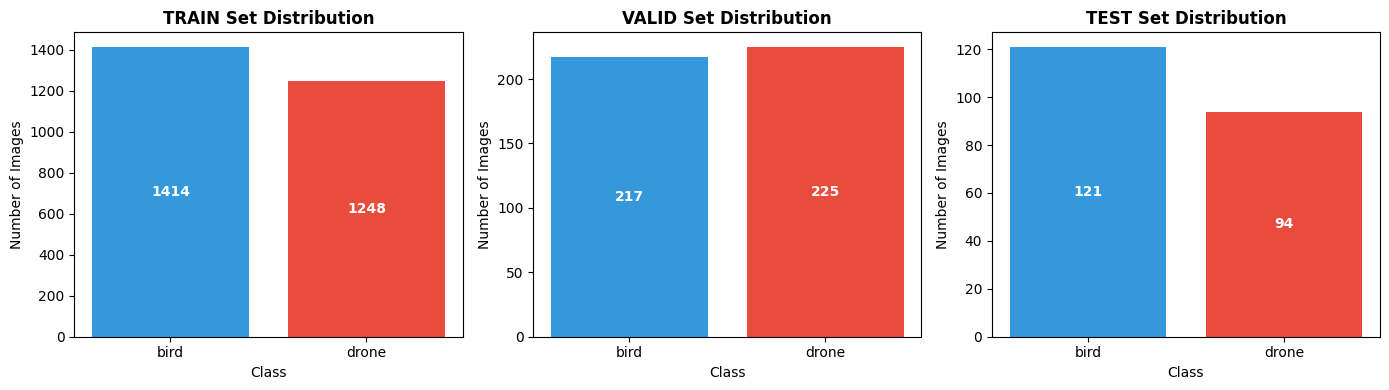

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, split in enumerate(['TRAIN', 'VALID', 'TEST']):
    split_data = df_counts[df_counts['Split'] == split]
    colors = ['#3498db', '#e74c3c']
    
    axes[idx].bar(split_data['Class'], split_data['Count'], color=colors)
    axes[idx].set_title(f'{split} Set Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Number of Images')

    # ---- LABELS INSIDE BARS ----
    for i, (cls, count) in enumerate(zip(split_data['Class'], split_data['Count'])):
        axes[idx].text(
            i, 
            count * 0.5,          # middle height
            str(count),
            ha='center',
            va='center',
            fontweight='bold',
            color='white' if count > 20 else 'black'   # white text if bar is tall
        )

plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=160, bbox_inches='tight')
plt.show()


In [5]:
train_data = df_counts[df_counts['Split'] == 'TRAIN']
total_train = train_data['Count'].sum()
print("\nClass Imbalance Analysis (Training Set):")
for _, row in train_data.iterrows():
    percentage = (row['Count'] / total_train) * 100
    print(f"  {row['Class']}: {row['Count']} images ({percentage:.1f}%)")



Class Imbalance Analysis (Training Set):
  bird: 1414 images (53.1%)
  drone: 1248 images (46.9%)


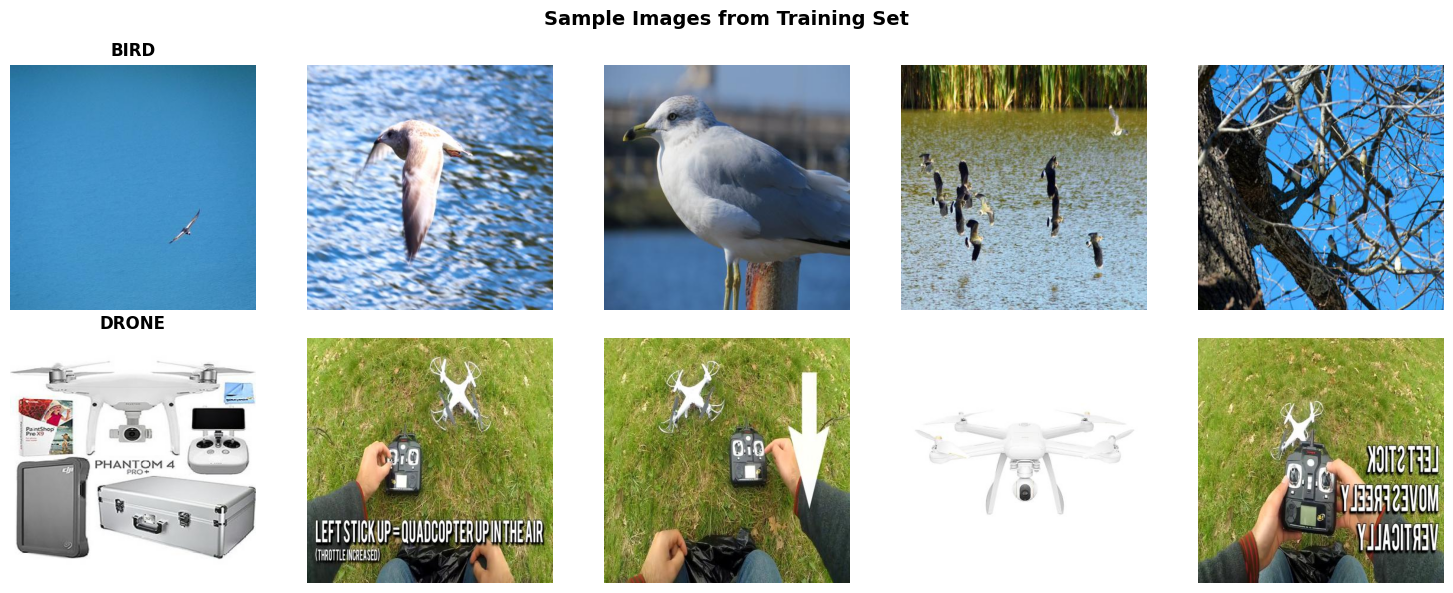

In [6]:
# Visualize sample images from each class
def display_sample_images(data_dir, class_names, samples_per_class=5):
    """Display sample images from each class"""
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                             figsize=(3*samples_per_class, 3*len(class_names)))
    
    for i, cls in enumerate(class_names):
        cls_path = os.path.join(data_dir, cls)
        images = os.listdir(cls_path)
        sample_images = random.sample(images, min(samples_per_class, len(images)))
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{cls.upper()}', fontsize=12, fontweight='bold')
    
    plt.suptitle('Sample Images from Training Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

display_sample_images(TRAIN_DIR, CLASS_NAMES)

In [7]:
# Check image properties (size, channels)
def analyze_image_properties(data_dir, num_samples=50):
    """Analyze image dimensions and properties"""
    widths, heights = [], []
    
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            images = os.listdir(cls_path)[:num_samples]
            for img_name in images:
                img_path = os.path.join(cls_path, img_name)
                try:
                    img = Image.open(img_path)
                    widths.append(img.size[0])
                    heights.append(img.size[1])
                except:
                    pass
    
    print("Image Dimension Statistics:")
    print(f"  Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.0f}")
    print(f"  Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.0f}")
    
    return widths, heights

widths, heights = analyze_image_properties(TRAIN_DIR)


Image Dimension Statistics:
  Width  - Min: 416, Max: 416, Mean: 416
  Height - Min: 416, Max: 416, Mean: 416


In [8]:
# Configuration
IMG_SIZE = (224, 224)  # Standard size for most pretrained models
BATCH_SIZE = 32
NUM_CLASSES = 2

print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")


Image Size: (224, 224)
Batch Size: 32
Number of Classes: 2


In [9]:
# Create ImageDataGenerators

# Training data generator WITH augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values to [0, 1]
    rotation_range=30,                 # Random rotation
    width_shift_range=0.2,             # Horizontal shift
    height_shift_range=0.2,            # Vertical shift
    shear_range=0.2,                   # Shear transformation
    zoom_range=0.2,                    # Random zoom
    horizontal_flip=True,              # Random horizontal flip
    vertical_flip=True,                # Random vertical flip
    brightness_range=[0.8, 1.2],       # Brightness adjustment
    fill_mode='nearest'                # Fill mode for new pixels
)

# Validation & Test data generator - ONLY rescaling (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# %%
# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

valid_generator = val_test_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# %%
# Print class indices
print("Class Indices:", train_generator.class_indices)
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {valid_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class Indices: {'bird': 0, 'drone': 1}

Training samples: 2662
Validation samples: 442
Test samples: 215


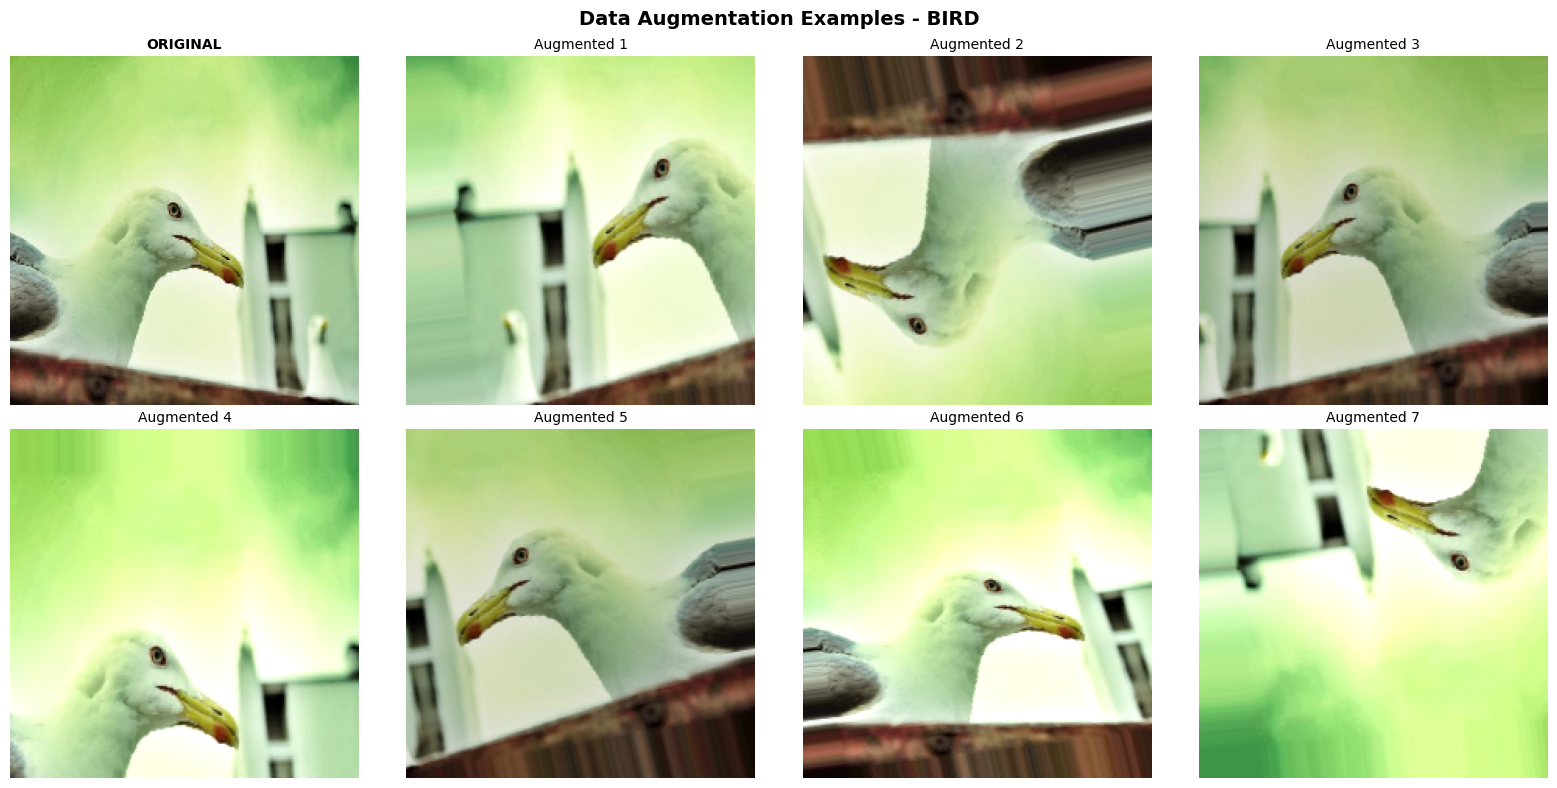

In [10]:
# Visualize augmented images
def visualize_augmentation(data_dir, class_name, num_augmented=6):
    """Visualize original vs augmented images"""
    cls_path = os.path.join(data_dir, class_name)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)
    
    # Load original image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    
    # Generate augmented images
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('ORIGINAL', fontsize=10, fontweight='bold')
    axes[0].axis('off')
    
    # Augmented images
    aug_iter = train_datagen.flow(img_array, batch_size=1)
    for i in range(1, 8):
        aug_img = next(aug_iter)[0]
        axes[i].imshow(aug_img)
        axes[i].set_title(f'Augmented {i}', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f'Data Augmentation Examples - {class_name.upper()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_augmentation(TRAIN_DIR, 'bird')

In [11]:
def build_custom_cnn():
    """Build a custom CNN architecture from scratch"""
    model = Sequential([
        # Input Layer
        Input(shape=(224, 224, 3)),
        
        # Convolutional Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Convolutional Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Convolutional Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Convolutional Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])
    
    return model

# %%
# Build and compile Custom CNN
custom_cnn = build_custom_cnn()

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("=" * 60)
print("CUSTOM CNN ARCHITECTURE")
print("=" * 60)
custom_cnn.summary()


I0000 00:00:1763906471.751453      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


CUSTOM CNN ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,001,377 (103.00 MB)

 Trainable params: 26,997,921 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [12]:
def build_transfer_model(base_model_name='resnet50', trainable=False):
    
    # Select base model
    if base_model_name == 'resnet50':
        base_model = ResNet50(
            weights='imagenet', 
            include_top=False, 
            input_shape=(224, 224, 3)
        )
    elif base_model_name == 'inceptionv3':
        base_model = InceptionV3(
            weights='imagenet', 
            include_top=False, 
            input_shape=(224, 224, 3)
        )
    else:
        raise ValueError(f"Unknown model: {base_model_name}")
    
    # Freeze/Unfreeze base model
    base_model.trainable = trainable
    
    # Build the model
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model, base_model

# %%
# Build Transfer Learning Models

# ResNet50
print("Building ResNet50...")
resnet_model, resnet_base = build_transfer_model('resnet50')
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# InceptionV3
print("Building InceptionV3...")
inceptionv3_model, inceptionv3_base = build_transfer_model('inceptionv3')
inceptionv3_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✅ All transfer learning models built successfully!")

# %%
# Display ResNet50 model summary
print("=" * 60)
print("RESNET50 TRANSFER LEARNING ARCHITECTURE")
print("=" * 60)
resnet_model.summary()

Building ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Building InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

✅ All transfer learning models built successfully!
RESNET50 TRANSFER LEARNING ARCHITECTURE


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [13]:
# Define callbacks
def get_callbacks(model_name):
    """Create callbacks for training"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'models/best_{model_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    return callbacks

# Create models directory
os.makedirs('models', exist_ok=True)

EPOCHS = 30


In [14]:
# Train Custom CNN
print("\n" + "=" * 60)
print("TRAINING CUSTOM CNN")
print("=" * 60)

history_cnn = custom_cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=get_callbacks('custom_cnn'),
    verbose=1
)



TRAINING CUSTOM CNN
Epoch 1/30


I0000 00:00:1763906495.934304      82 service.cc:148] XLA service 0x7cd2ec0028d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763906495.935138      82 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763906496.997443      82 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/84 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4844 - loss: 0.9177  

I0000 00:00:1763906511.297624      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.5923 - loss: 0.8670
Epoch 1: val_accuracy improved from -inf to 0.49095, saving model to models/best_custom_cnn.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 98s 907ms/step - accuracy: 0.5927 - loss: 0.8662 - val_accuracy: 0.4910 - val_loss: 1.1602 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6827 - loss: 0.6979
Epoch 2: val_accuracy did not improve from 0.49095
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - accuracy: 0.6829 - loss: 0.6977 - val_accuracy: 0.4910 - val_loss: 1.1144 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7063 - loss: 0.6435
Epoch 3: val_accuracy did not improve from 0.49095
84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 451ms/step - accuracy: 0.7064 - loss: 0.6431 - val_accuracy: 0.4887 - val_loss: 0.9196 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7168 - loss: 0.5956
Epoch 4: val_accuracy did not improve fro

In [15]:
# %%
# Train ResNet50
print("\n" + "=" * 60)
print("TRAINING RESNET50 (Feature Extraction)")
print("=" * 60)

history_resnet = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=get_callbacks('resnet50'),
    verbose=1
)



TRAINING RESNET50 (Feature Extraction)
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6403 - loss: 0.7458
Epoch 1: val_accuracy improved from -inf to 0.50452, saving model to models/best_resnet50.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 64s 603ms/step - accuracy: 0.6405 - loss: 0.7450 - val_accuracy: 0.5045 - val_loss: 0.8603 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6934 - loss: 0.6146
Epoch 2: val_accuracy improved from 0.50452 to 0.51131, saving model to models/best_resnet50.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 477ms/step - accuracy: 0.6934 - loss: 0.6146 - val_accuracy: 0.5113 - val_loss: 1.2578 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6972 - loss: 0.5870
Epoch 3: val_accuracy improved from 0.51131 to 0.58371, saving model to models/best_resnet50.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 472ms/step - accuracy: 0.6973 - loss: 0.5869 - val_accuracy: 0.5837 - val_loss: 1.0759 - lear

In [16]:
# Train InceptionV3
print("\n" + "=" * 60)
print("TRAINING INCEPTIONV3 (Feature Extraction)")
print("=" * 60)

history_inceptionv3 = inceptionv3_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=get_callbacks('inceptionv3'),
    verbose=1
)


TRAINING INCEPTIONV3 (Feature Extraction)
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8350 - loss: 0.3652
Epoch 1: val_accuracy improved from -inf to 0.89593, saving model to models/best_inceptionv3.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 678ms/step - accuracy: 0.8356 - loss: 0.3639 - val_accuracy: 0.8959 - val_loss: 0.2512 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9386 - loss: 0.1715
Epoch 2: val_accuracy improved from 0.89593 to 0.95928, saving model to models/best_inceptionv3.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 470ms/step - accuracy: 0.9386 - loss: 0.1715 - val_accuracy: 0.9593 - val_loss: 0.1138 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9371 - loss: 0.1609
Epoch 3: val_accuracy did not improve from 0.95928
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - accuracy: 0.9372 - loss: 0.1608 - val_accuracy: 0.9525 - val_loss: 0.1144 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━

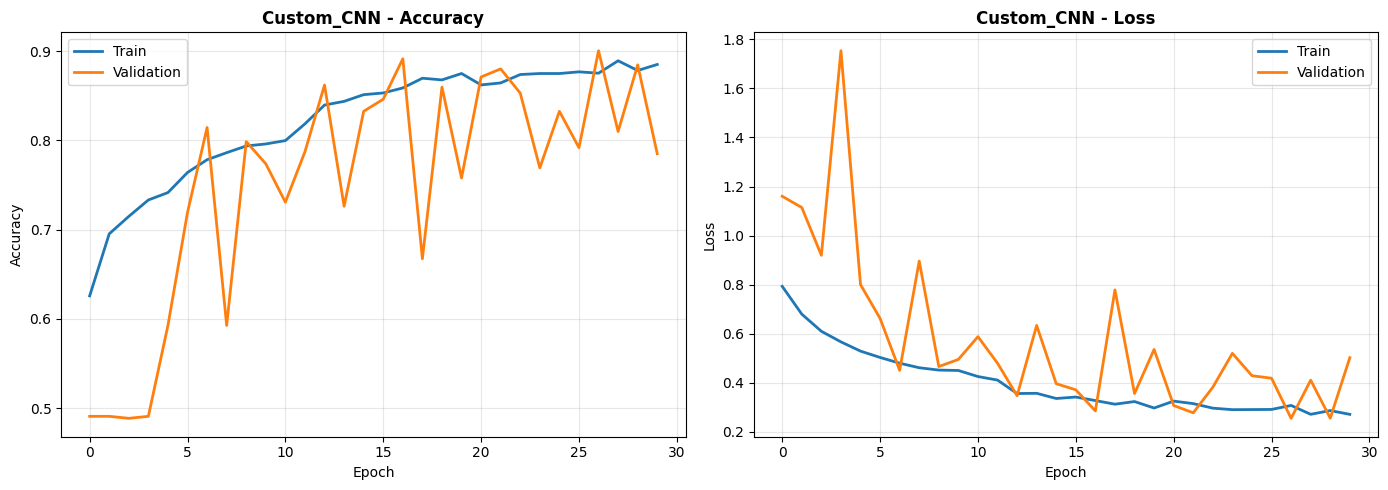

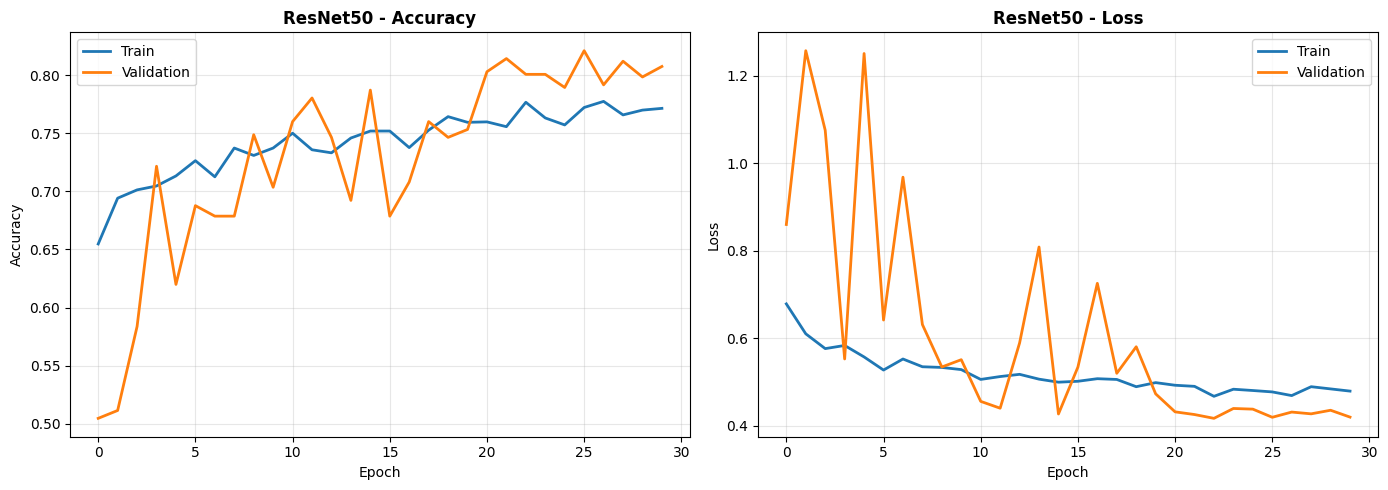

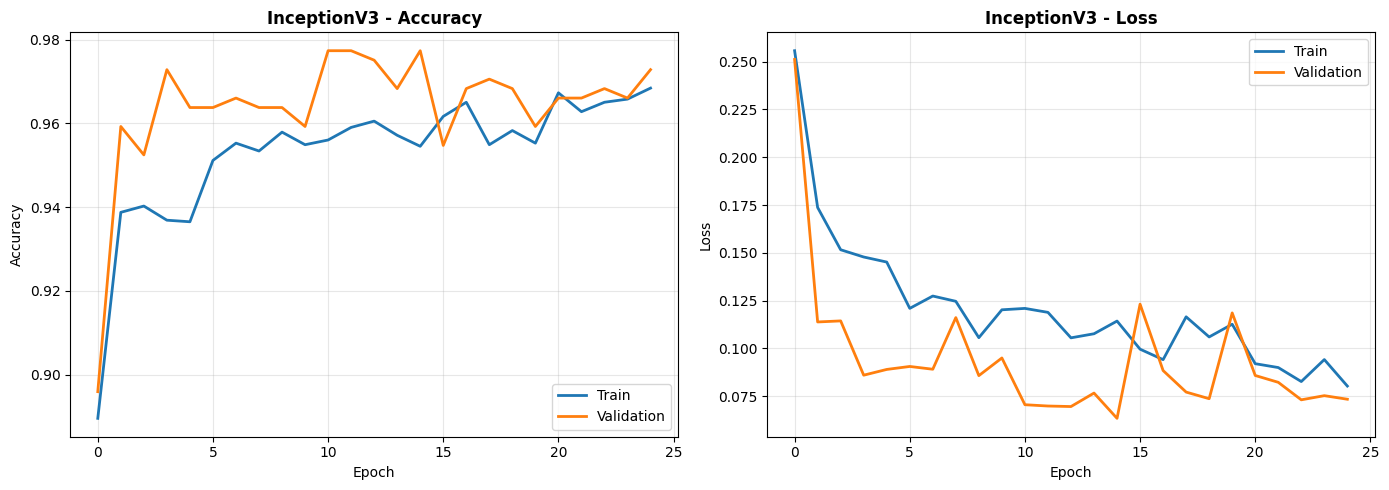

In [17]:
def plot_training_history(history, model_name):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot training histories
plot_training_history(history_cnn, 'Custom_CNN')
plot_training_history(history_resnet, 'ResNet50')
plot_training_history(history_inceptionv3, 'InceptionV3')


EVALUATING Custom_CNN
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 697ms/step

📊 Classification Report:
              precision    recall  f1-score   support

        bird       0.90      0.96      0.93       121
       drone       0.94      0.86      0.90        94

    accuracy                           0.92       215
   macro avg       0.92      0.91      0.91       215
weighted avg       0.92      0.92      0.92       215



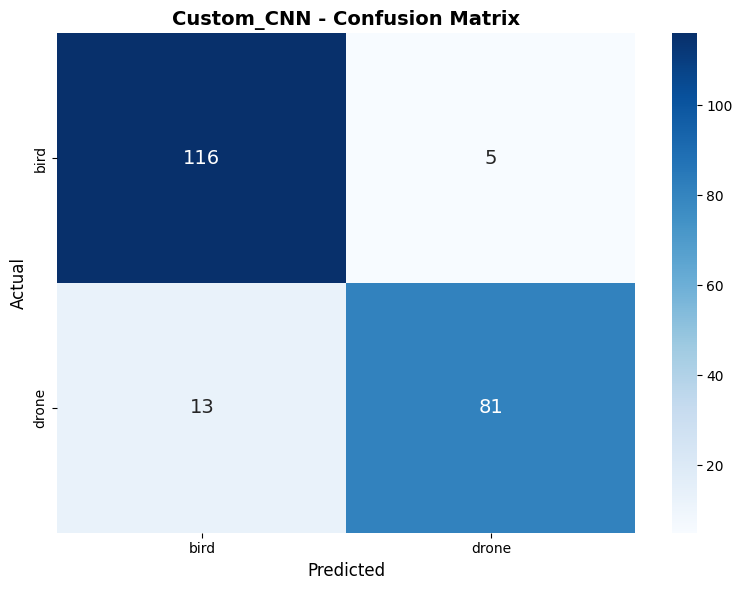


EVALUATING ResNet50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 847ms/step

📊 Classification Report:
              precision    recall  f1-score   support

        bird       0.84      0.86      0.85       121
       drone       0.81      0.79      0.80        94

    accuracy                           0.83       215
   macro avg       0.83      0.82      0.82       215
weighted avg       0.83      0.83      0.83       215



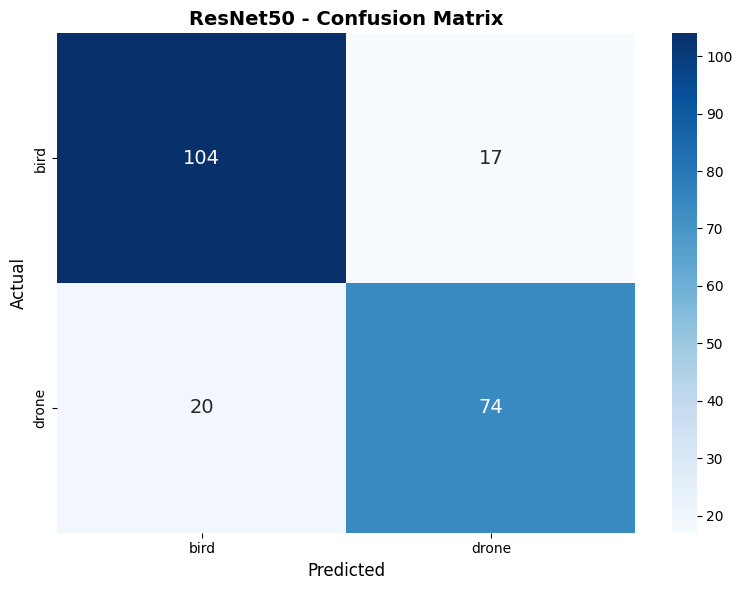


EVALUATING InceptionV3
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step

📊 Classification Report:
              precision    recall  f1-score   support

        bird       0.94      0.98      0.96       121
       drone       0.97      0.93      0.95        94

    accuracy                           0.95       215
   macro avg       0.96      0.95      0.95       215
weighted avg       0.95      0.95      0.95       215



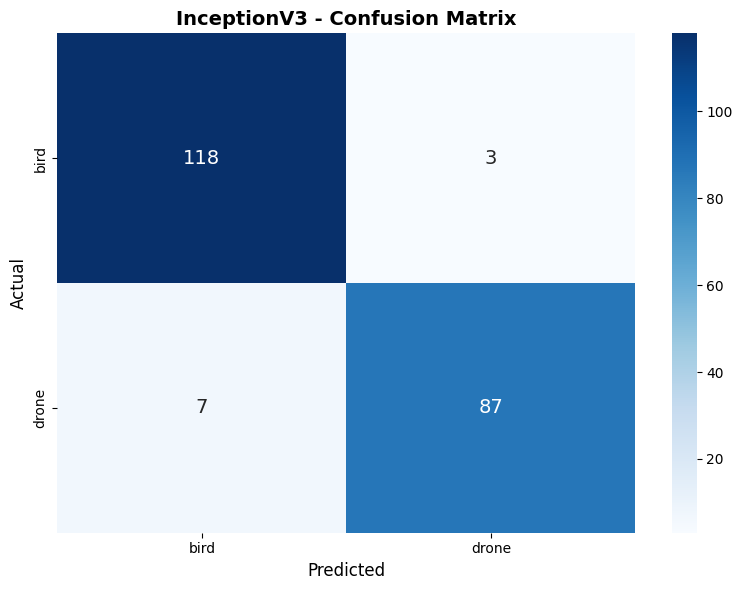

In [18]:
def evaluate_model(model, test_generator, model_name):
    """Comprehensive model evaluation"""
    print(f"\n{'=' * 60}")
    print(f"EVALUATING {model_name}")
    print(f"{'=' * 60}")
    
    # Reset generator
    test_generator.reset()
    
    # Get predictions
    y_pred_proba = model.predict(test_generator, verbose=1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    y_true = test_generator.classes
    
    # Test loss and accuracy
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    
    # Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                annot_kws={'size': 14})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return {
        'model_name': model_name,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'y_pred': y_pred,
        'y_true': y_true
    }

# %%
# Evaluate all models
results = []

results.append(evaluate_model(custom_cnn, test_generator, 'Custom_CNN'))
results.append(evaluate_model(resnet_model, test_generator, 'ResNet50'))
results.append(evaluate_model(inceptionv3_model, test_generator, 'InceptionV3'))



📊 MODEL COMPARISON:
      Model  Test Accuracy  Test Loss
InceptionV3       0.953488   0.146860
 Custom_CNN       0.916279   0.261154
   ResNet50       0.827907   0.397791


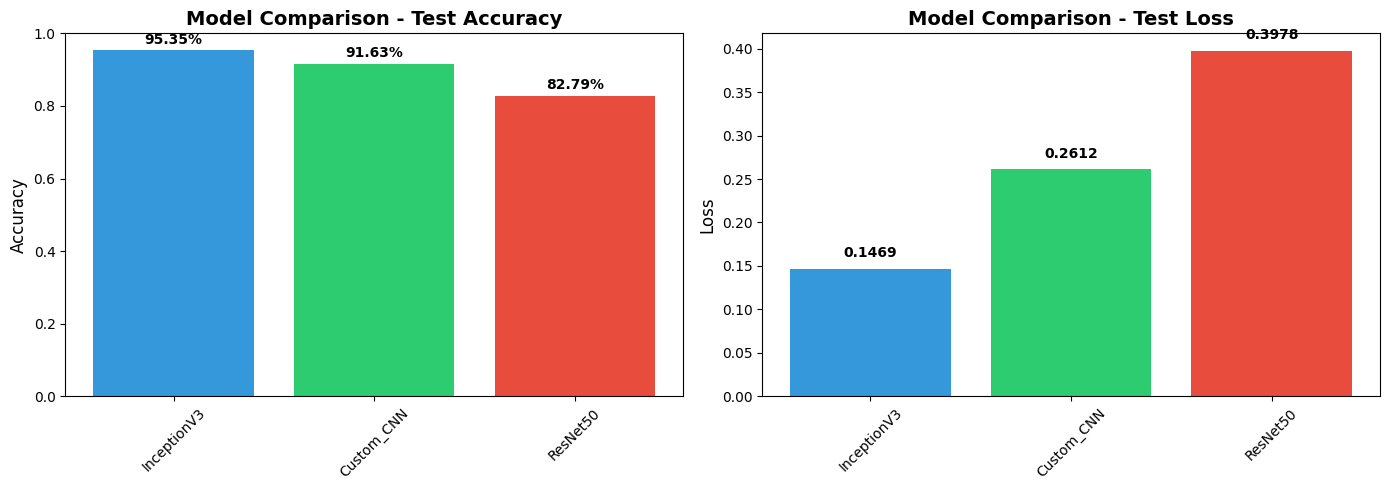

In [19]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {'Model': r['model_name'], 
     'Test Accuracy': r['test_accuracy'], 
     'Test Loss': r['test_loss']} 
    for r in results
])

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print("\n📊 MODEL COMPARISON:")
print(comparison_df.to_string(index=False))

# %%
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars1 = axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], color=colors)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

# Loss comparison
bars2 = axes[1].bar(comparison_df['Model'], comparison_df['Test Loss'], color=colors)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Comparison - Test Loss', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [20]:
# Find best model
best_model_info = comparison_df.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model_info['Model']}")
print(f"   Test Accuracy: {best_model_info['Test Accuracy']:.2%}")
print(f"   Test Loss: {best_model_info['Test Loss']:.4f}")

# Save all models
custom_cnn.save('models/custom_cnn_final.keras')
resnet_model.save('models/resnet50_final.keras')
inceptionv3_model.save('models/inceptionv3_final.keras')

print("✅ All models saved to 'models/' directory")

# %%
# Save the best model for Streamlit deployment
best_model_name = best_model_info['Model'].lower().replace('_', '')

# Copy best model to deployment folder
import shutil
os.makedirs('streamlit_app', exist_ok=True)

if 'cnn' in best_model_name:
    shutil.copy('models/custom_cnn_final.keras', 'streamlit_app/best_model.keras')
elif 'resnet' in best_model_name:
    shutil.copy('models/resnet50_final.keras', 'streamlit_app/best_model.keras')
elif 'inception' in best_model_name:
    shutil.copy('models/inceptionv3_final.keras', 'streamlit_app/best_model.keras')

print(f"✅ Best model ({best_model_info['Model']}) saved for Streamlit deployment")



🏆 BEST MODEL: InceptionV3
   Test Accuracy: 95.35%
   Test Loss: 0.1469
✅ All models saved to 'models/' directory
✅ Best model (InceptionV3) saved for Streamlit deployment
